In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

def localization_and_crop_image(
    img_path, 
    model_path='checkpoints/localization_best.pt',
    class_names=None,
    save_classes=None,
    conf_start=0.46,
    conf_min=0.05,
    imgsz=640,
    device='0',
    verbose=False,
    collect_stats=False
):
    # Set default values if not provided
    if class_names is None:
        class_names = ['DIA', 'PUL', 'SYS', 'Sphygmomanometer']
    
    if save_classes is None:
        save_classes = [0, 1, 2]  # 0: DIA, 1: PUL, 2: SYS
    
    # Load model
    model = YOLO(model_path)
    
    # Read image
    img = cv2.imread(img_path)
    
    conf = conf_start
    successful = False
    cropped_images = {}  # Dictionary to store cropped images
    img_with_boxes = None
    
    # Dictionary to store statistics if requested
    detection_stats = {} if collect_stats else None
    if collect_stats:
        detection_stats = {
            'confidence': [],
            'SYS': [],
            'DIA': [],
            'PUL': []
        }
    
    while conf >= conf_min and not successful:
        if verbose:
            print(f"Trying with confidence threshold: {conf:.2f}")
        
        # Clear previous results
        cropped_images = {}
        
        # Perform inference
        results = model(img_path, imgsz=imgsz, conf=conf, device=device, verbose=verbose)
        
        # Make a copy for drawing boxes if needed
        img_with_boxes = img.copy()
        
        # Track detections for statistics
        class_counts = {class_names[i]: 0 for i in save_classes}
        
        # Process results
        for i, result in enumerate(results):
            boxes = result.boxes.xyxy.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy().astype(int)
            
            for j, (box, cls) in enumerate(zip(boxes, classes)):
                if cls in save_classes:
                    x1, y1, x2, y2 = map(int, box)
                    crop_img = img[y1:y2, x1:x2]
                    
                    class_name = class_names[cls]
                    if class_name not in cropped_images:
                        cropped_images[class_name] = []
                    
                    cropped_images[class_name].append(crop_img)
                    class_counts[class_name] += 1
                    
                    # Draw bounding box
                    if class_name == 'SYS':
                        color = (0, 255, 0)  # Green
                    elif class_name == 'DIA':
                        color = (0, 0, 255)  # Red
                    elif class_name == 'PUL':
                        color = (255, 0, 0)  # Blue
                    else:
                        color = (255, 255, 0)  # Cyan
                        
                    cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 8)
                    # Get text size for background rectangle
                    text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 5, 5)[0]
                    # Add padding to the background rectangle
                    padding = 15
                    # Draw the background rectangle
                    cv2.rectangle(img_with_boxes, (x1, y1-15-text_size[1]-padding), (x1+text_size[0]+padding, y1-15), color, -1)
                    # Draw the text with a contrasting color
                    text_color = (0, 0, 0) if sum(color) > 382 else (255, 255, 255)
                    cv2.putText(img_with_boxes, class_name, (x1+padding//2, y1-15-padding//2), cv2.FONT_HERSHEY_SIMPLEX, 5, text_color, 5)
        
        # Record statistics if requested
        if collect_stats:
            detection_stats['confidence'].append(conf)
            for class_name in ['SYS', 'DIA', 'PUL']:
                count = class_counts.get(class_name, 0)
                detection_stats[class_name].append(count)
        
        # Check if each class has exactly one image
        all_classes_have_one_image = True
        for cls in [class_names[i] for i in save_classes]:
            if cls not in cropped_images or len(cropped_images[cls]) != 1:
                images_count = 0 if cls not in cropped_images else len(cropped_images[cls])
                all_classes_have_one_image = False
                if verbose:
                    print(f"Class {cls} has {images_count} images, expecting 1")
                break
        
        if all_classes_have_one_image:
            successful = True
            if verbose:
                print(f"Successfully found one image for each class with conf={conf:.2f}")
        else:
            conf -= 0.01
    
    if not successful:
        if verbose:
            print(f"Could not find exactly one image for each class. Minimum conf {conf_min} reached.")
        return None
    
    # Extract the single image for each class
    result_images = {}
    for cls in ['SYS', 'DIA', 'PUL']:
        if cls in cropped_images and len(cropped_images[cls]) > 0:
            result_images[cls] = cropped_images[cls][0]
    
    # Add the boxed image to results
    result_images['boxed_image'] = img_with_boxes
    
    # Add statistics if collected
    if collect_stats:
        result_images['detection_stats'] = detection_stats
            
    return result_images

In [2]:
import matplotlib.pyplot as plt 

def cut_out_3_numbers(image, show=False):
    reshaped_image = cv2.resize(image, (1000, 500))
    # Extract three segments of the image based on x-coordinates
    first_segment = reshaped_image[:, 0:210, :]
    second_segment = reshaped_image[:, 210:600, :]
    third_segment = reshaped_image[:, 600:1000, :]

    if show:    
        # Display the segments
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(first_segment, cv2.COLOR_BGR2RGB))
        plt.title('First Segment (0-200)')
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(second_segment, cv2.COLOR_BGR2RGB))
        plt.title('Second Segment (200-600)')
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(third_segment, cv2.COLOR_BGR2RGB))
        plt.title('Third Segment (600-1000)')
        plt.show()

    return first_segment, second_segment, third_segment

def cut_out_2_numbers(image, show=False):
    reshaped_image = cv2.resize(image, (1000, 500))
    # Extract three segments of the image based on x-coordinates
    first_segment = reshaped_image[:, 0:500, :]
    second_segment = reshaped_image[:, 500:1000, :]

    if show:
        # Display the segments
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(first_segment, cv2.COLOR_BGR2RGB))
        plt.title('First Segment (0-500)')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(second_segment, cv2.COLOR_BGR2RGB))
        plt.title('Second Segment (500-1000)')
        plt.show()

    return first_segment, second_segment

In [3]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.models import resnet18

import torch.nn as nn
import torchvision.transforms as transforms

def load_model(model_path, device):
    """
    Load the trained seven segment classifier model
    
    Args:
        model_path (str): Path to the saved model weights
        device (torch.device): Device to run the model on
        
    Returns:
        model (torch.nn.Module): Loaded model
    """
    model = resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    return model

def preprocess_image(image):
    """
    Preprocess an image for inference
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        tensor (torch.Tensor): Preprocessed image tensor
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.fromarray(image).convert('RGB')
    image_tensor = transform(image)
    return image_tensor.unsqueeze(0)  # Add batch dimension

def inference_single_image(model, image_path, device):
    """
    Run inference on a single image
    
    Args:
        model (torch.nn.Module): Loaded model
        image_path (str): Path to the image file
        device (torch.device): Device to run inference on
        
    Returns:
        pred (int): Predicted digit
        confidence (float): Confidence score
    """
    image_tensor = preprocess_image(image_path).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, prediction = torch.max(probabilities, 1)
    
    return prediction.item(), confidence.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
model = load_model('checkpoints/seven_seg_classification_best.pth', device)

Using device: cuda


In [4]:
from PIL import Image, ImageEnhance
import os
import matplotlib.pyplot as plt
import numpy as np

def adjust_image(image, output_path=None, brightness_factor=1.0, contrast_factor=1.0, sharpness_factor=1.0, color_factor=1.0, show=False, save=False):
    """
    調整圖片的亮度、對比度、銳利度和色彩飽和度。

    Args:
        image_path (str): 輸入圖片的路徑。
        output_path (str): 輸出圖片的路徑。
        brightness_factor (float): 亮度調整因子。1.0 表示不變，大於 1.0 變亮，小於 1.0 變暗。
        contrast_factor (float): 對比度調整因子。1.0 表示不變，大於 1.0 增加對比，小於 1.0 降低對比。
        sharpness_factor (float): 銳利度調整因子 (增豔)。1.0 表示不變，大於 1.0 增加銳利度，小於 1.0 模糊。
        color_factor (float): 色彩飽和度調整因子 (增豔)。1.0 表示不變，大於 1.0 增加飽和度，小於 1.0 降低飽和度。
    """
    # 打開圖片
    image = Image.fromarray(image).convert("RGB")  # 確保圖片是 RGB 模式

    # 調整亮度 (亮部)
    enhancer_b = ImageEnhance.Brightness(image)
    img_bright = enhancer_b.enhance(brightness_factor)

    # 調整對比度
    enhancer_c = ImageEnhance.Contrast(img_bright)
    img_contrast = enhancer_c.enhance(contrast_factor)

    # 調整銳利度 (增豔 - 銳利度方面)
    enhancer_s = ImageEnhance.Sharpness(img_contrast)
    img_sharp = enhancer_s.enhance(sharpness_factor)

    # 調整色彩飽和度 (增豔 - 色彩方面)
    enhancer_col = ImageEnhance.Color(img_sharp)
    img_final = enhancer_col.enhance(color_factor)
    
    if show:
        # 展示原圖和調整後的圖片對比
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(image))
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(np.array(img_final))
        plt.title('Adjusted Image')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    if output_path and save:
        img_final.save(output_path)
    
    return np.array(img_final)  # 返回調整後的圖片數組

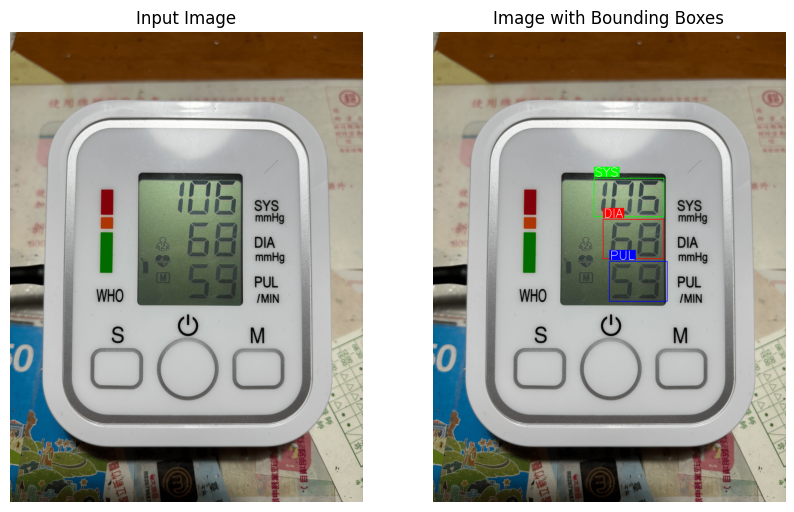

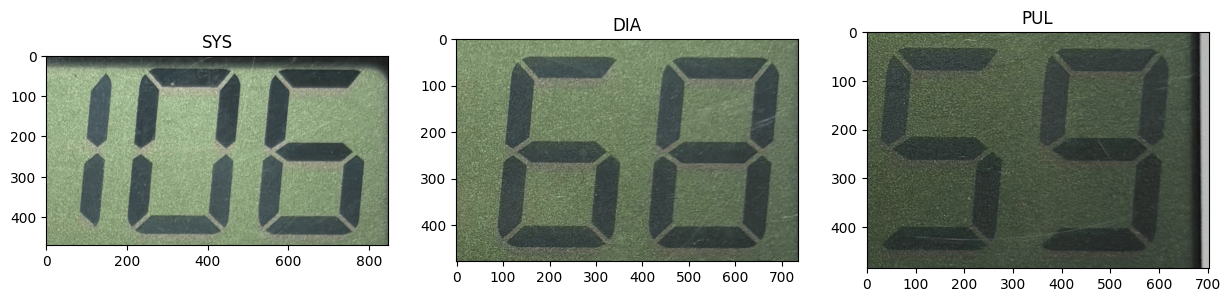

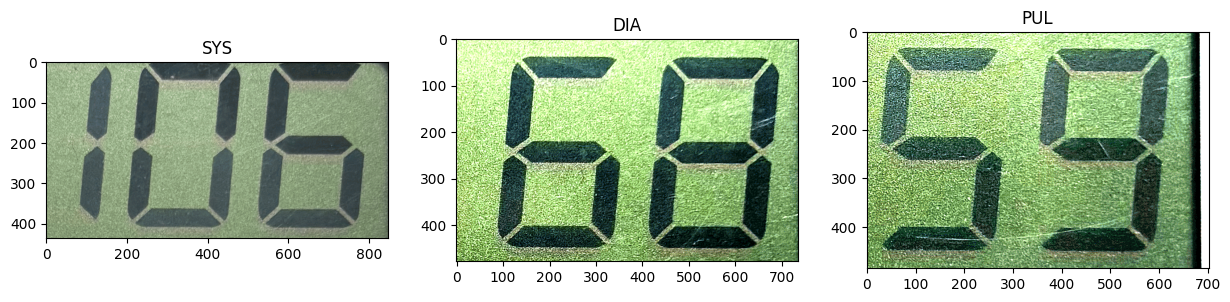

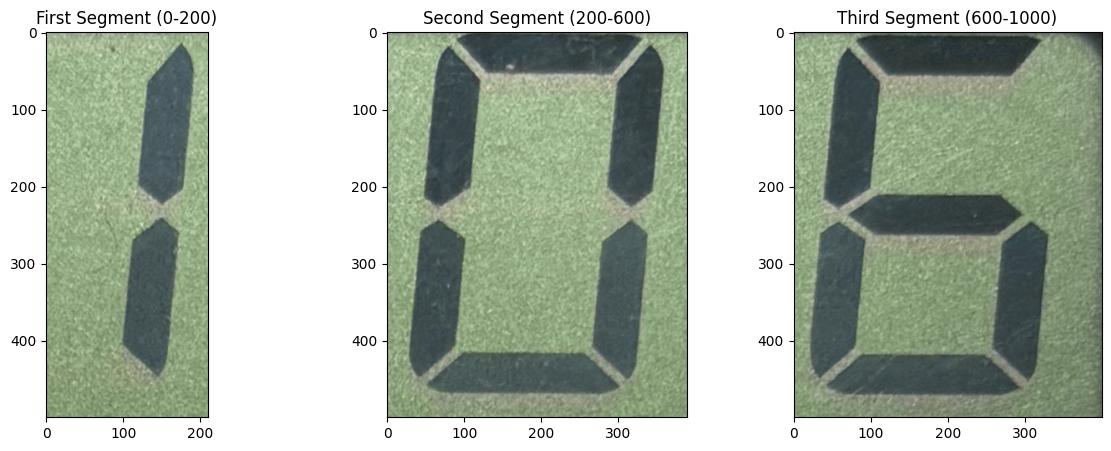

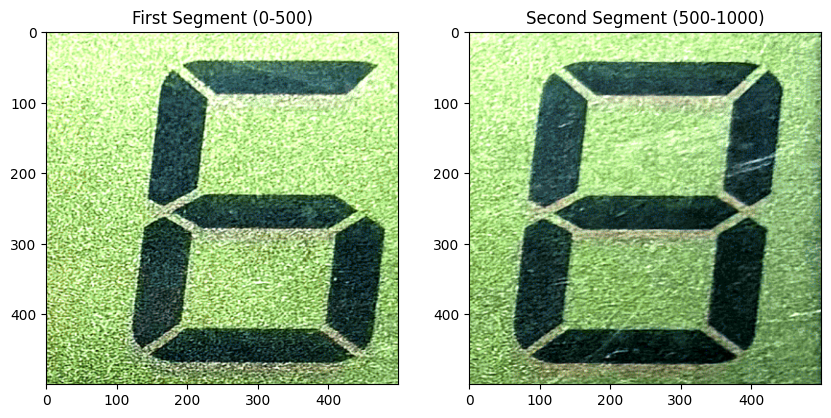

image: my_images/IMG_1992.png, SYS: 106, DIA: 68, PUL: 59


In [12]:
import os 
import matplotlib.pyplot as plt 

image_folder = 'my_images'

results = []
for image in sorted(os.listdir(image_folder)):

    image = os.path.join(image_folder, image)
    result_images = localization_and_crop_image(image, collect_stats=True)

    stats = result_images.get('detection_stats')
    results.append(stats['confidence'][-1])
    
    sys_image = result_images.get('SYS')
    dia_image = result_images.get('DIA')
    pul_image = result_images.get('PUL')
    boxed_image = result_images.get('boxed_image')

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    plt.title('Input Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(sys_image, cv2.COLOR_BGR2RGB))
    plt.title('SYS')
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(dia_image, cv2.COLOR_BGR2RGB))
    plt.title('DIA')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(pul_image, cv2.COLOR_BGR2RGB))
    plt.title('PUL')
    plt.show()

    # Calculate 5% of the image height
    crop_height = int(sys_image.shape[0] * 0.07)
    sys_image = sys_image[crop_height:, :, :]

    dia_image = adjust_image(dia_image, brightness_factor=1.5, contrast_factor=2.0, sharpness_factor=2.0, color_factor=1.0)
    pul_image = adjust_image(pul_image, brightness_factor=2.0, contrast_factor=2.0, sharpness_factor=2.0, color_factor=1.0)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(sys_image, cv2.COLOR_BGR2RGB))
    plt.title('SYS')
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(dia_image, cv2.COLOR_BGR2RGB))
    plt.title('DIA')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(pul_image, cv2.COLOR_BGR2RGB))
    plt.title('PUL')
    plt.show()
    
    sys_number, dia_number, pul_number = '', '', ''

    if sys_image.shape[1] / dia_image.shape[1] > 1.05:
        sys_digits = cut_out_3_numbers(sys_image, show=True)
    else:
        sys_digits = cut_out_2_numbers(sys_image)

    for digit in sys_digits:
        prediction, _ = inference_single_image(model, digit, device)
        sys_number += str(prediction)
    sys_number = int(sys_number)
    
    dia_digits = cut_out_2_numbers(dia_image, show=True)
    for digit in dia_digits:
        prediction, _ = inference_single_image(model, digit, device)
        dia_number += str(prediction)
    dia_number = int(dia_number)

    pul_digits = cut_out_2_numbers(pul_image)
    for digit in pul_digits:
        prediction, _ = inference_single_image(model, digit, device)
        pul_number += str(prediction)
    pul_number = int(pul_number)
    
    print(f"image: {image}, SYS: {sys_number}, DIA: {dia_number}, PUL: {pul_number}")
    results.append((sys_number, dia_number, pul_number))

    break

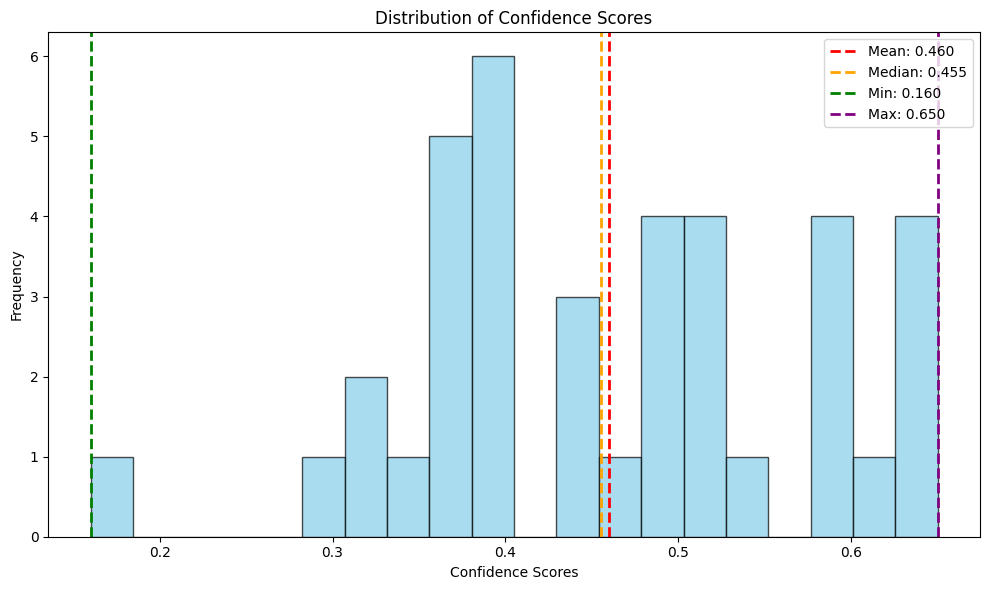

In [8]:
# Create a histogram to visualize the distribution of confidence scores
plt.figure(figsize=(10, 6))
plt.hist(results, bins=20, alpha=0.7, color='skyblue', edgecolor='black')

# Add lines for mean, median, min and max values
mean_val = np.mean(np.array(results))
median_val = np.median(np.array(results))  # Calculate median
min_val = np.min(np.array(results))
max_val = np.max(np.array(results))

plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.3f}')
plt.axvline(median_val, color='orange', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.3f}')  # Add median line
plt.axvline(min_val, color='green', linestyle='dashed', linewidth=2, label=f'Min: {min_val:.3f}')
plt.axvline(max_val, color='purple', linestyle='dashed', linewidth=2, label=f'Max: {max_val:.3f}')

# Add labels and title
plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores')
plt.legend()
plt.tight_layout()
plt.show()